## Train on Letters DataSet and FineTune using Numbers Dataset

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
from torchsummary import summary

In [4]:
letters_train = torchvision.datasets.EMNIST("../data", split="letters", train=True, download=True, transform=T.ToTensor())
letters_test = torchvision.datasets.EMNIST("../data", split="letters", train=False, download=True, transform=T.ToTensor())

In [5]:
len(letters_train), len(letters_test)

(124800, 20800)

In [7]:
letters_test[0][0].shape

torch.Size([1, 28, 28])

In [10]:
l_train_data = torch.Tensor(np.array([x[0] for x in letters_train]))
l_train_labels = torch.tensor(np.array([x[1]-1 for x in letters_train]), dtype=torch.long)
l_test_data = torch.Tensor(np.array([x[0] for x in letters_test]))
l_test_labels = torch.tensor(np.array([x[1]-1 for x in letters_test]), dtype=torch.long)
l_train_ds = TensorDataset(l_train_data, l_train_labels)
l_test_ds = TensorDataset(l_test_data, l_test_labels)
l_train_loader = DataLoader(l_train_ds, batch_size=16, shuffle=True, drop_last=True)
l_test_loader = DataLoader(l_test_ds, batch_size=l_test_ds.tensors[0].shape[0])

In [12]:
def create_letter_model():
    class LetterNet(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.enc = nn.Sequential(
                nn.Conv2d(1, 10, 3, 1, 1),
                nn.BatchNorm2d(10),
                nn.ReLU(),
                nn.MaxPool2d(2), # 14
                nn.Conv2d(10, 5, 3, 1, 1),
                nn.BatchNorm2d(5),
                nn.ReLU(),
                nn.MaxPool2d(2), # 7
                nn.Flatten(), # 7*7*5
            )
            self.lat = nn.Sequential(
                nn.Linear(7*7*5, 128),
                nn.Dropout(p=.2),
                nn.ReLU(),
                nn.Linear(128, 26),
            )
        def forward(self, x):
            x = self.enc(x)
            return self.lat(x)
    net = LetterNet()
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)
    return net, lossfunc, optimizer

In [13]:
net, lossfunc, _ = create_letter_model()
lx, ly = next(iter(l_train_loader))
ly_pred = net(lx)
print(ly_pred.shape, ly_pred)
loss = lossfunc(ly_pred, ly)
loss

torch.Size([16, 26]) tensor([[ 0.1899, -0.4978, -0.0243,  0.3431, -0.1642,  0.3017, -0.0650,  0.0645,
          0.0513,  0.1361,  0.0969, -0.2356,  0.3293,  0.3598, -0.6238,  0.9323,
          0.2888, -0.0090,  0.2373, -0.2961, -0.1097, -0.1443, -0.1700, -0.5932,
          0.1725, -0.3732],
        [ 0.2617,  0.1173,  0.0898,  0.5207, -0.0113, -0.2172, -0.0813,  0.1627,
         -0.3615, -0.3188, -0.2175, -0.2612,  0.0317,  0.3083, -0.6048,  0.2478,
         -0.0160, -0.2137,  0.2459, -0.0027,  0.2497, -0.1487,  0.0362,  0.2860,
         -0.2723, -0.0873],
        [ 0.0423, -0.2997,  0.0586, -0.0285, -0.3125, -0.0962, -0.0279,  0.1983,
          0.0786, -0.2681,  0.0398, -0.2257, -0.0167, -0.2960, -0.0554,  0.9128,
          0.1252,  0.1420,  0.2535,  0.3348,  0.3428,  0.0761,  0.1155, -0.4037,
         -0.0048, -0.3472],
        [-0.2659, -0.2425, -0.3495,  0.0202,  0.0460,  0.2085, -0.0489,  0.1241,
          0.2047, -0.0257, -0.3880, -0.3011,  0.0875,  0.6696, -0.6934,  0.7901,
    

tensor(3.3677, grad_fn=<NllLossBackward0>)

In [14]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [16]:
def train_model(net, lossfunc, optimizer, train_loader, test_loader, epochs=10):
    train_acc, test_acc, train_loss, test_loss = [], [], [], []
    for ei in range(epochs):
        net.to(device=device)
        batch_acc, batch_loss = [], []
        for x, y in train_loader:
            x = x.to(device=device)
            y = y.to(device=device)
            y_pred = net(x)
            loss = lossfunc(y_pred, y)
            acc = 100*torch.mean((torch.argmax(y_pred, axis=1)==y).float()).cpu().item()
            batch_acc.append(acc)
            batch_loss.append(loss.cpu().item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_acc.append(np.mean(batch_acc).item())
        train_loss.append(np.mean(batch_loss).item())

        net.eval()
        with torch.no_grad():
            x, y = next(iter(test_loader))
            x = x.to(device=device)
            y = y.to(device=device)
            y_test = net(x)
            test_loss.append(lossfunc(y_test, y).cpu().item())
            test_acc.append(100*torch.mean((torch.argmax(y_test, axis=1)==y).float()).cpu().item())
        print(f"Epoch: {ei}, Train acc: {train_acc[-1]:.2f}, Test acc: {test_acc[-1]:.2f}, Train loss: {train_loss[-1]:.2f}, Test loss: {test_loss[-1]:.2f}")
    return train_acc, test_acc, train_loss, test_loss, net

In [18]:
l_net, l_lossfunc, l_optimizer = create_letter_model()
l_train_acc, l_test_acc, l_train_loss, l_test_loss, l_net = train_model(l_net, l_lossfunc, l_optimizer, l_train_loader, l_test_loader)

Epoch: 0, Train acc: 82.68, Test acc: 90.33, Train loss: 0.55, Test loss: 0.30
Epoch: 1, Train acc: 91.15, Test acc: 91.69, Train loss: 0.27, Test loss: 0.26
Epoch: 2, Train acc: 92.25, Test acc: 91.83, Train loss: 0.23, Test loss: 0.25
Epoch: 3, Train acc: 92.89, Test acc: 92.17, Train loss: 0.21, Test loss: 0.25
Epoch: 4, Train acc: 93.29, Test acc: 92.13, Train loss: 0.20, Test loss: 0.24
Epoch: 5, Train acc: 93.59, Test acc: 92.55, Train loss: 0.18, Test loss: 0.23
Epoch: 6, Train acc: 93.79, Test acc: 92.45, Train loss: 0.18, Test loss: 0.23
Epoch: 7, Train acc: 94.08, Test acc: 92.81, Train loss: 0.17, Test loss: 0.23
Epoch: 8, Train acc: 94.33, Test acc: 92.52, Train loss: 0.16, Test loss: 0.23
Epoch: 9, Train acc: 94.49, Test acc: 92.49, Train loss: 0.15, Test loss: 0.23


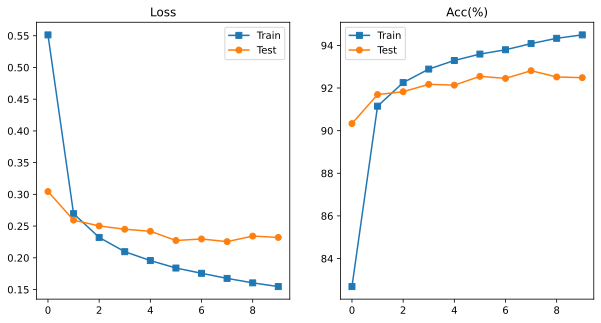

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(l_train_loss, "s-")
ax[0].plot(l_test_loss, "o-")
ax[0].legend(["Train", "Test"])
ax[0].set_title("Loss")

ax[1].plot(l_train_acc, "s-")
ax[1].plot(l_test_acc, "o-")
ax[1].legend(["Train", "Test"])
ax[1].set_title("Acc(%)")

plt.show()

In [19]:
torch.save(l_net.state_dict(), "letters_model.pt")

## Now that we have a trained letters model, we will move to preparing Digit model

In [20]:
digits_train = torchvision.datasets.EMNIST("../data", split="digits", train=True, download=True, transform=T.ToTensor())
digits_test = torchvision.datasets.EMNIST("../data", split="digits", train=False, download=True, transform=T.ToTensor())
len(digits_train), len(digits_test)

(240000, 40000)

In [22]:
digits_train.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [23]:
d_train_data = torch.Tensor(np.array([x[0] for x in digits_train]))
d_train_labels = torch.tensor(np.array([x[1] for x in digits_train]), dtype=torch.long)
d_test_data = torch.Tensor(np.array([x[0] for x in digits_test]))
d_test_labels = torch.tensor(np.array([x[1] for x in digits_test]), dtype=torch.long)
d_train_ds = TensorDataset(d_train_data, d_train_labels)
d_test_ds = TensorDataset(d_test_data, d_test_labels)
d_train_loader = DataLoader(d_train_ds, batch_size=16, shuffle=True, drop_last=True)
d_test_loader = DataLoader(d_test_ds, batch_size=d_test_ds.tensors[0].shape[0])

In [27]:
def create_digits_model():
    class DigitNet(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.enc = nn.Sequential(
                nn.Conv2d(1, 10, 3, 1, 1),
                nn.BatchNorm2d(10),
                nn.ReLU(),
                nn.MaxPool2d(2), # 14
                nn.Conv2d(10, 5, 3, 1, 1),
                nn.BatchNorm2d(5),
                nn.ReLU(),
                nn.MaxPool2d(2), # 7
                nn.Flatten(), # 7*7*5
            )
            self.lat = nn.Sequential(
                nn.Linear(7*7*5, 128),
                nn.Dropout(p=.2),
                nn.ReLU(),
                nn.Linear(128, 10),
            )
        def forward(self, x):
            x = self.enc(x)
            return self.lat(x)
    net = DigitNet()
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)
    return net, lossfunc, optimizer

#### Test digit data on Letter trained 26 output model

In [31]:
dx, dy = next(iter(d_test_loader))
dx = dx.to(device=device)
dy = dy.to(device=device)
l_net.eval()
with torch.no_grad():
    dy_test = l_net(dx)
    acc = 100*torch.mean((torch.argmax(dy_test, axis=1)==dy).float()).cpu().item()
print(f"LetterNet trained model performance on Digit Test Set is {acc:.2f}")

LetterNet trained model performance on Digit Test Set is 3.56


#### Scratch trained DigitNet Model performance on Digit Test Set

In [28]:
ds_net, ds_lossfunc, ds_optimizer = create_digits_model()
ds_train_acc, ds_test_acc, ds_train_loss, ds_test_loss, ds_net = train_model(ds_net, ds_lossfunc, ds_optimizer, d_train_loader, d_test_loader, epochs=1)

Epoch: 0, Train acc: 97.71, Test acc: 98.93, Train loss: 0.08, Test loss: 0.04


#### Copying trained LetterNet Conv Block params into fresh LetterNet model and replace last layer with 10 units

In [41]:
import copy

In [43]:
df_net, df_lossfunc, df_optimizer = create_letter_model()

for target, source in zip(df_net.named_parameters(), l_net.named_parameters()):
    target[1].data = copy.deepcopy(source[1].data)

df_net

LetterNet(
  (enc): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (lat): Sequential(
    (0): Linear(in_features=245, out_features=128, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=26, bias=True)
  )
)

In [49]:
l_net.lat[0].weight

Parameter containing:
tensor([[-0.0025,  0.1695,  0.1020,  ..., -0.5051, -0.1382,  0.3983],
        [-0.2120,  0.1404, -0.0492,  ..., -0.2786, -0.0055,  0.1865],
        [-0.2099, -0.0024,  0.1581,  ..., -0.2850, -0.1068,  0.0024],
        ...,
        [-0.1447, -0.5012, -0.0568,  ..., -0.3608,  0.4719,  0.4329],
        [-0.1756,  0.0593, -0.1293,  ..., -0.0815, -0.0293, -0.7258],
        [ 0.1113, -0.6306, -0.6875,  ..., -0.2004, -0.4221, -0.1672]],
       device='cuda:0', requires_grad=True)

In [45]:
df_net.lat[3].weight

Parameter containing:
tensor([[-4.7692e-01, -2.0125e-01, -4.6188e-01,  ...,  6.6146e-03,
         -7.9690e-01,  3.0503e-01],
        [-1.6607e-01, -2.6931e-01, -3.0474e-01,  ...,  1.2114e-01,
         -1.5139e+00, -5.9455e-01],
        [-6.9544e-01, -2.5815e-01, -5.1440e-01,  ..., -1.0467e-01,
         -4.7632e-01,  7.2026e-02],
        ...,
        [ 3.7834e-01,  3.1194e-01, -7.7289e-01,  ..., -5.7068e-01,
         -1.0485e+00, -1.2263e+00],
        [ 3.9049e-01,  1.8793e-01, -7.0598e-01,  ..., -2.7511e-01,
         -3.1694e-02,  2.3532e-01],
        [ 1.2726e-01, -1.7612e-01, -7.0015e-04,  ..., -1.3267e+00,
         -1.4589e+00, -2.8935e-01]], device='cuda:0', requires_grad=True)

In [46]:
df_net.lat[3] = nn.Linear(128, 10, device=device)

In [47]:
df_net.lat[3].weight

Parameter containing:
tensor([[-0.0630,  0.0710, -0.0780,  ...,  0.0109,  0.0798, -0.0318],
        [-0.0321, -0.0191, -0.0670,  ..., -0.0648, -0.0045,  0.0278],
        [-0.0266, -0.0406,  0.0787,  ..., -0.0743,  0.0637,  0.0483],
        ...,
        [ 0.0519,  0.0592, -0.0420,  ..., -0.0054, -0.0597,  0.0412],
        [ 0.0387, -0.0607,  0.0448,  ...,  0.0609, -0.0514, -0.0696],
        [ 0.0726, -0.0105, -0.0522,  ..., -0.0368,  0.0323, -0.0061]],
       device='cuda:0', requires_grad=True)

In [50]:
df_net.lat[0].weight

Parameter containing:
tensor([[-0.0025,  0.1695,  0.1020,  ..., -0.5051, -0.1382,  0.3983],
        [-0.2120,  0.1404, -0.0492,  ..., -0.2786, -0.0055,  0.1865],
        [-0.2099, -0.0024,  0.1581,  ..., -0.2850, -0.1068,  0.0024],
        ...,
        [-0.1447, -0.5012, -0.0568,  ..., -0.3608,  0.4719,  0.4329],
        [-0.1756,  0.0593, -0.1293,  ..., -0.0815, -0.0293, -0.7258],
        [ 0.1113, -0.6306, -0.6875,  ..., -0.2004, -0.4221, -0.1672]],
       device='cuda:0', requires_grad=True)

In [51]:
df_net

LetterNet(
  (enc): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (lat): Sequential(
    (0): Linear(in_features=245, out_features=128, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

### Have trained all the layers

In [52]:
df_train_acc, df_test_acc, df_train_loss, df_test_loss, df_net = train_model(df_net, df_lossfunc, df_optimizer, d_train_loader, d_test_loader, epochs=1)

Epoch: 0, Train acc: 96.95, Test acc: 99.04, Train loss: 0.10, Test loss: 0.03


### Model performance is slightly better than scratch

## Now train only the output layer

In [71]:
df2_net, df2_lossfunc, df2_optimizer = create_letter_model()

for target, source in zip(df2_net.named_parameters(), l_net.named_parameters()):
    target[1].data = copy.deepcopy(source[1].data)

df2_net

LetterNet(
  (enc): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (lat): Sequential(
    (0): Linear(in_features=245, out_features=128, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=26, bias=True)
  )
)

In [72]:
df2_net.lat[3] = nn.Linear(128, 10, device=device)

# Set grad to false for all conv and batch layers

In [73]:
df2_net.enc[0].weight[0]

tensor([[[-0.1208,  0.5886, -0.3138],
         [-0.2538,  0.2269, -0.2723],
         [ 0.0379,  0.1279,  0.1881]]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [74]:
df2_net

LetterNet(
  (enc): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (lat): Sequential(
    (0): Linear(in_features=245, out_features=128, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [75]:
for p in df2_net.named_parameters():
    print(p[0])

enc.0.weight
enc.0.bias
enc.1.weight
enc.1.bias
enc.4.weight
enc.4.bias
enc.5.weight
enc.5.bias
lat.0.weight
lat.0.bias
lat.3.weight
lat.3.bias


In [80]:
# setting encoder layer to freeze
for p in df2_net.named_parameters():
    if "enc" in p[0]:
        p[1].requires_grad = False

In [81]:
df2_train_acc, df2_test_acc, df2_train_loss, df2_test_loss, df2_net = train_model(df2_net, df2_lossfunc, df2_optimizer, d_train_loader, d_test_loader, epochs=1)

Epoch: 0, Train acc: 95.98, Test acc: 98.66, Train loss: 0.15, Test loss: 0.04


In [82]:
df2_net.enc[0].weight[0]

tensor([[[-0.1208,  0.5886, -0.3138],
         [-0.2538,  0.2269, -0.2723],
         [ 0.0379,  0.1279,  0.1881]]], device='cuda:0')

#### Encoder layer weights havent changed after training as required_grad was set to false